In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import HDFStore
store = HDFStore("RGA_RunData_Oct2022.h5")
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default="plotly_white"
pio.renderers.default = 'jupyterlab'  # Alternate: 'browser' opens new browser window with plots.


In [2]:
df = [None, None, None]
df[0] = store['/period_0/All_Runs']
df[1] = store['/period_1/All_Runs']
df[2] = store['/period_2/All_Runs']

In [3]:
# Read Rafo's data again.
rafo_new_charge = pd.read_fwf("Run_Charge.dat", names=["run_number", "gated_charge", "ungated_charge", "max_gated_charge", "min_gated_charge",
                                                       "max_ungated_charge", "min_ungated_charge"])
rafo_new_charge.drop(["max_gated_charge", "min_gated_charge", "max_ungated_charge", "min_ungated_charge"], axis=1, inplace=True)

runs = df[1].copy()
runs.drop(rafo_new_charge.keys(), axis=1, inplace=True)
runs.reset_index(inplace=True)
runs = pd.merge(runs, rafo_new_charge, left_on="number", right_on="run_number", how="left")
runs.set_index("number", inplace=True)

In [4]:

# runs.drop( runs.loc[runs.target == "empty"].index, inplace=True)     # Drop Empty target runs.
runs.drop(runs.loc[ runs.data_start.isnull() ].index, inplace=True)
runs.drop(runs.loc[ runs.start_time.isnull() ].index, inplace=True)
runs.drop(runs.loc[ runs.end_time.isnull() ].index, inplace=True)
runs["center"] = runs.start_time + (runs.end_time - runs.start_time)/2
runs["dt"] = (runs.end_time - runs.start_time).map(lambda x: x.total_seconds()*1000)
runs["hover"] = runs.index.map(lambda x: f"Run: {x}, target: {runs.loc[x,'target']}")
runs.drop(runs.loc[ (runs.dt <= 0) ].index, inplace=True)
runs["event_rate"] = runs.event_count/runs.dt
# runs.loc[:,["events_rate", "event_rate"]]

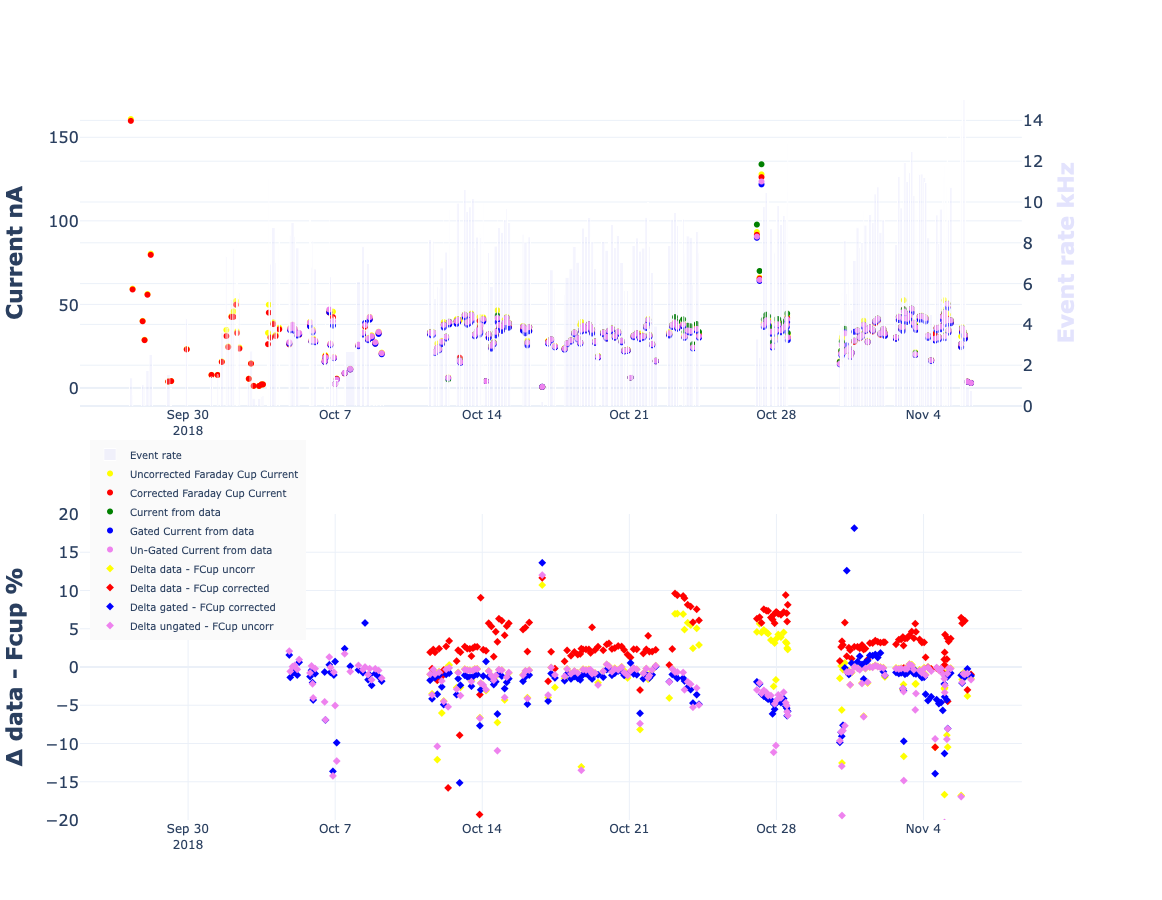

In [5]:
fig = make_subplots(rows=2, specs=[[{"secondary_y": True}],[{}]])
fig.update_layout(height=900, width=1200,
                  #title=go.layout.Title(text=f"Charge comparison for RGA", xanchor="left", x=0.4),
                  #titlefont=dict(size=24),
                  )
fig.add_trace(go.Bar(x=runs.center, y=runs.event_rate, width=runs.dt, name="Event rate", hovertext=runs.hover, marker=dict(color='rgba(200,200,250,0.2)') ), row=1, col=1, secondary_y=True)
fig.add_trace(go.Scatter(x=runs.center, y=1E9*runs.Fcup_charge/runs.dt, name="Uncorrected Faraday Cup Current", hovertext=runs.hover, mode="markers", marker=dict(color="yellow")), row=1, col=1)
fig.add_trace(go.Scatter(x=runs.center, y=1E9*runs.Fcup_charge_corr/runs.dt, name="Corrected Faraday Cup Current", hovertext=runs.hover, mode="markers", marker=dict(color="red")), row=1, col=1)
fig.add_trace(go.Scatter(x=runs.center, y=1E9*runs.data_charge/runs.dt, name="Current from data", mode="markers", hovertext=runs.hover, marker=dict(color="green")), row=1, col=1)
fig.add_trace(go.Scatter(x=runs.center, y=1E9*runs.gated_charge/runs.dt, name="Gated Current from data", mode="markers", hovertext=runs.hover, marker=dict(color="blue")), row=1, col=1)
fig.add_trace(go.Scatter(x=runs.center, y=1E9*runs.ungated_charge/runs.dt, name="Un-Gated Current from data", mode="markers", hovertext=runs.hover, marker=dict(color="violet")), row=1, col=1)

diff_corr = 100*( (runs.data_charge - runs.Fcup_charge_corr)/runs.data_charge )
diff_uncorr = 100*( (runs.data_charge - runs.Fcup_charge)/runs.data_charge )
diff_corr_gated = 100*((runs.gated_charge - runs.Fcup_charge_corr)/runs.gated_charge)
diff_corr_ungated = 100*((runs.ungated_charge - runs.Fcup_charge)/runs.ungated_charge)

fig.add_trace(go.Scatter(x=runs.center, y=diff_uncorr, name="Delta data - FCup uncorr",
                         mode="markers", hovertext=runs.hover, marker=dict(color="yellow", symbol="diamond")), row=2, col=1)

fig.add_trace(go.Scatter(x=runs.center, y=diff_corr, name="Delta data - FCup corrected",
                         mode="markers", hovertext=runs.hover, marker=dict(color="red", symbol="diamond")), row=2, col=1)

fig.add_trace(go.Scatter(x=runs.center, y=diff_corr_gated, name="Delta gated - FCup corrected",
                         mode="markers", hovertext=runs.hover, marker=dict(color="blue", symbol="diamond")), row=2, col=1)

fig.add_trace(go.Scatter(x=runs.center, y=diff_corr_ungated, name="Delta ungated - FCup uncorr",
                         mode="markers", hovertext=runs.hover, marker=dict(color="violet", symbol="diamond")), row=2, col=1)


fig.update_yaxes(title_text="<b>Current nA</b>", titlefont=dict(size=22), secondary_y=False, tickfont=dict(size=16), row=1, col=1)
fig.update_yaxes(title_text="<b>Event rate kHz</b>", titlefont=dict(size=22, color='rgba(200,200,250,0.5)'), secondary_y=True, tickfont=dict(size=16),range = [0, 15.], row=1, col=1)
fig.update_yaxes(title_text="<b>Δ data - Fcup %</b>", titlefont=dict(size=22), secondary_y=False, tickfont=dict(size=16),range = [-20., 20.], row=2, col=1)

fig.update_layout(legend=dict(
                x=0.01,
                y=0.25,
                bgcolor="rgba(250,250,250,1.)",
                font=dict(
                    size=10
                ),
                #orientation='h'
            ))
fig.write_html("RGA_charge.html")
fig.write_image("RGA_charge.pdf", width=2048, height=900)
fig.show()

In [17]:
print(f"Average difference for first group, run 4930 - 5001. Corrected FCup: {np.average(diff_corr.loc[4930:5001]):7.3f}, Uncorrected FCup {np.average(diff_uncorr.loc[4930:5001]):7.3f}")

Average difference for first group, run 4930 - 5001. Corrected FCup:     nan, Uncorrected FCup     nan


In [18]:
print(f"Average difference for first group, run 5038 - 5419 . Corrected FCup: {np.average(diff_corr.loc[5038:5419]):7.3f}, Uncorrected FCup {np.average(diff_uncorr.loc[5038:5419]):7.3f}")

Average difference for first group, run 5038 - 5419 . Corrected FCup:   2.997, Uncorrected FCup  -2.538


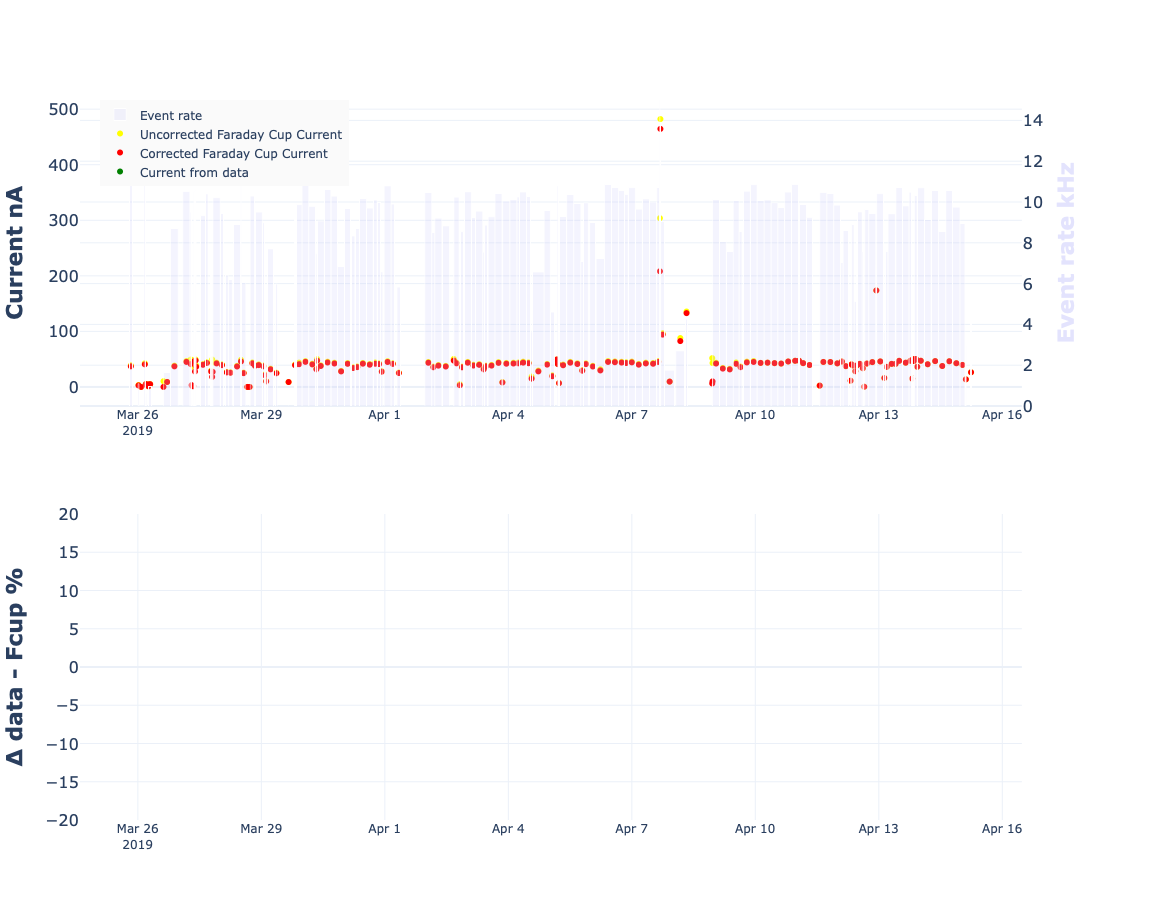

In [19]:
runs = df[2].copy()
#runs.drop(runs.loc[ runs.data_start.isnull() ].index, inplace=True)
runs.drop(runs.loc[ runs.start_time.isnull() ].index, inplace=True)
runs.drop(runs.loc[ runs.end_time.isnull() ].index, inplace=True)
runs["center"] = runs.start_time + (runs.end_time - runs.start_time)/2
runs["dt"] = (runs.end_time - runs.start_time).map(lambda x: x.total_seconds()*1000)
runs["hover"] = runs.index.map(lambda x: f"Run: {x}, target: {runs.loc[x,'target']}")
runs.drop(runs.loc[ (runs.dt <= 0) ].index, inplace=True)
runs["event_rate"] = runs.event_count/runs.dt
runs.loc[:,["events_rate", "event_rate"]]

fig = make_subplots(rows=2, specs=[[{"secondary_y": True}],[{}]])
fig.update_layout(height=900, width=1200,
                  #title=go.layout.Title(text=f"Charge comparison for RGA", xanchor="left", x=0.4),
                  #titlefont=dict(size=24),
                  )
fig.add_trace(go.Bar(x=runs.center, y=runs.event_rate, width=runs.dt, name="Event rate", hovertext=runs.hover, marker=dict(color='rgba(200,200,250,0.2)') ), row=1, col=1, secondary_y=True)
fig.add_trace(go.Scatter(x=runs.center, y=1E9*runs.Fcup_charge/runs.dt, name="Uncorrected Faraday Cup Current", hovertext=runs.hover, mode="markers", marker=dict(color="yellow")), row=1, col=1)
fig.add_trace(go.Scatter(x=runs.center, y=1E9*runs.Fcup_charge_corr/runs.dt, name="Corrected Faraday Cup Current", hovertext=runs.hover, mode="markers", marker=dict(color="red")), row=1, col=1)
fig.add_trace(go.Scatter(x=runs.center, y=1E9*runs.data_charge/runs.dt, name="Current from data", mode="markers", hovertext=runs.hover, marker=dict(color="green")), row=1, col=1)

diff_corr = 100*( (runs.data_charge - runs.Fcup_charge_corr)/runs.data_charge )
diff_uncorr = 100*( (runs.data_charge - runs.Fcup_charge)/runs.data_charge )
fig.add_trace(go.Scatter(x=runs.center, y=diff_uncorr, name="Delta data - FCup uncorr",
                         mode="markers", hovertext=runs.hover, marker=dict(color="yellow"), showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=runs.center, y=diff_corr, name="Delta data - FCup corrected",
                         mode="markers", hovertext=runs.hover, marker=dict(color="red"), showlegend=False), row=2, col=1)


fig.update_yaxes(title_text="<b>Current nA</b>", titlefont=dict(size=22), secondary_y=False, tickfont=dict(size=16), row=1, col=1)
fig.update_yaxes(title_text="<b>Event rate kHz</b>", titlefont=dict(size=22, color='rgba(200,200,250,0.5)'), secondary_y=True, tickfont=dict(size=16),range = [0, 15.], row=1, col=1)
fig.update_yaxes(title_text="<b>Δ data - Fcup %</b>", titlefont=dict(size=22), secondary_y=False, tickfont=dict(size=16),range = [-20., 20.], row=2, col=1)
fig.update_layout(legend=dict(
                x=0.02,
                y=1.,
                bgcolor="rgba(250,250,250,1.)",
                font=dict(
                    size=12
                ),
                #orientation='h'
            ))
fig.write_html("RGA_charge3.html")
fig.write_image("RGA_charge3.pdf", width=2048, height=900)
fig.show()

In [16]:
runs = df[2].copy()
print(len(runs))
#runs.drop(runs.loc[ runs.data_start.isnull() ].index, inplace=True)
runs.drop(runs.loc[ runs.start_time.isnull() ].index, inplace=True)
runs.drop(runs.loc[ runs.end_time.isnull() ].index, inplace=True)
print(len(runs))

176
175


In [3]:
df[1].keys()

Index(['start_time', 'end_time', 'is_valid_run_end', 'user_comment',
       'run_type', 'target', 'beam_current_request', 'operators',
       'event_count', 'events_rate', 'run_config', 'status',
       'evio_files_count', 'megabyte_count', 'run_start_time', 'run_end_time',
       'beam_energy', 'selected', 'run_number', 'charge', 't_start', 't_end',
       'data_start', 'data_end', 'data_charge', 'gated_charge',
       'ungated_charge', 'IPM2C21A', 'B_DAQ:livetime_pulser', 'IPM2C21A_corr',
       'IPM2C21A_lumi', 'luminosity', 'IPM2C24A', 'IPM2C24A_corr',
       'IPM2C24A_lumi', 'scaler_calc1b', 'scaler_calc1b_corr',
       'scaler_calc1b_lumi', 'Fcup_charge', 'Fcup_charge_corr'],
      dtype='object')

In [27]:
runs.gated_charge.iloc[30:]

number
4906         NaN
4930         NaN
4931    0.147725
4932    0.442209
4933    0.171846
          ...   
5415    0.061213
5416    0.179638
5417    0.184391
5418    0.053388
5419    0.041394
Name: gated_charge, Length: 202, dtype: float64

In [11]:
runs.loc[runs.target == "empty"].index

Int64Index([4764, 4765, 4779, 4780, 4781, 4782, 4862, 4930, 4961, 4973, 5219,
            5220, 5301, 5302],
           dtype='int64', name='number')

In [8]:
runs.loc[ (runs.dt <= 0) ].index

Int64Index([], dtype='int64', name='number')

In [10]:
rafo_new_charge.keys()

Index(['run_number', 'gated_charge', 'ungated_charge'], dtype='object')

In [11]:
runs = df[1].copy()

In [16]:
runs.keys()

Index(['start_time', 'end_time', 'is_valid_run_end', 'user_comment',
       'run_type', 'target', 'beam_current_request', 'operators',
       'event_count', 'events_rate', 'run_config', 'status',
       'evio_files_count', 'megabyte_count', 'run_start_time', 'run_end_time',
       'beam_energy', 'selected', 'charge', 't_start', 't_end', 'data_start',
       'data_end', 'data_charge', 'IPM2C21A', 'B_DAQ:livetime_pulser',
       'IPM2C21A_corr', 'IPM2C21A_lumi', 'luminosity', 'IPM2C24A',
       'IPM2C24A_corr', 'IPM2C24A_lumi', 'scaler_calc1b', 'scaler_calc1b_corr',
       'scaler_calc1b_lumi', 'Fcup_charge', 'Fcup_charge_corr', 'run_number',
       'gated_charge', 'ungated_charge'],
      dtype='object')